# Importação e preparação dos dados

In [1]:
import pandas as pd

df = pd.read_csv('../dados/jurisprudencia_selecionada_excertos.CSV', sep = ';')
df.head()

,COD,NUM_ENUNCIADO,COD_AREA,DESCR_AREA,COD_TEMA,DESCR_TEMA,COD_SUBTEMA,DESCR_SUBTEMA,COD_DOC_TRAMITAVEL_EXCERTO,TEXTO_EXCERTO,ACORDAO,TIPO_PROCESSO
0,1400,1236,50,Responsabilidade,488,Solidariedade,261,Benefício previdenciário,54995438,Voto:Cuidam os autos de tomada de contas espec...,Acórdão 297/2016 - PL,Tomada de Contas Especial
1,1700,1534,46,Finanças Públicas,981,Exportação,983,Petróleo,55025603,Voto:Cuidam os autos de Solicitação do Congres...,Acórdão 366/2016 - PL,Solicitação do Congresso Nacional
2,5700,5314,50,Responsabilidade,203,Multa,1021,Dosimetria,55455375,Relatório:Trata-se de embargos de declaração o...,Acórdão 944/2016 - PL,Acompanhamento
3,284,40,45,Direito Processual,162,Princípio da independência das instâncias,481,Decisão judicial,54773747,Voto:8. Em relação a outros processos judiciai...,Acórdão 30/2016 - PL,Tomada de Contas Especial
4,298,54,49,Pessoal,141,Sistema S,142,Nepotismo,54773403,Voto:11. Relativamente ao ato envolvendo a Sra...,Acórdão 55/2016 - PL,Representação


In [2]:
df.shape

(13285, 12)

In [3]:
from sklearn.preprocessing import LabelBinarizer

areas = df.groupby(['DESCR_AREA']).groups.keys()
lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
y = lbArea.transform(df['DESCR_AREA'])
y.shape

(13285, 10)

In [4]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 70000
limite_texto = 2000
dim_vetor = 100

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['TEXTO_EXCERTO'])

sequences = tokenizer.texts_to_sequences(df['TEXTO_EXCERTO'])

word_index = tokenizer.word_index
vocabulario = len(word_index) + 1
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 63925 unique tokens.


In [5]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (13285, 2000)


In [6]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('../externos/model.txt')

/home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [7]:
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocabulario, dim_vetor))

ok = 0
for word, i in tokenizer.word_index.items():
    if word in model:
        embedding_matrix[i] = model[word]
        ok += 1
print('Vocabulario:', i)
print('Encontrados no modelo:', ok, '=', ok * 100. / i)

Vocabulario: 63925
Encontrados no modelo: 42309 = 66.18537348455222


In [8]:
x.shape, y.shape

((13285, 2000), (13285, 10))

# Treinamento

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=False))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W1201 00:55:20.977986 140632674797376 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1201 00:55:21.128664 140632674797376 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1201 00:55:21.130525 140632674797376 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1201 00:55:21.140298 140632674797376 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 100)         6392600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1994, 32)          22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 398, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 392, 32)           7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 6,422,562
Trainable params: 29,962
Non-trainable params: 6,392,600
_____________________________________________________________

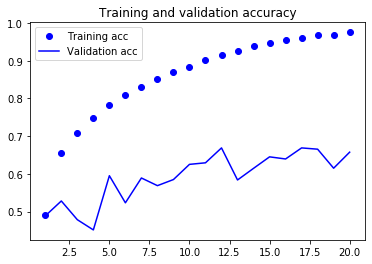

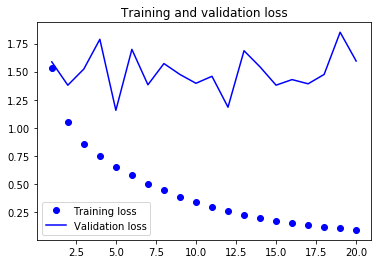

In [11]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 100)         6392600   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1994, 32)          22432     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 398, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 392, 32)           7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 6,422,562
Trainable params: 6,422,562
Non-trainable params: 0
_________________________________________________________________


In [13]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=5e-3),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 100)         6392600   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1994, 32)          22432     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 398, 32)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 392, 32)           7200      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 6,422,562
Trainable params: 6,422,562
Non-trainable params: 0
_________________________________________________________________


In [14]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GRU(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W1201 01:00:16.681195 140632674797376 deprecation.py:506] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2000, 100)         6392600   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1994, 32)          22432     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 398, 32)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 392, 32)           7200      
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               221952    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 6,646,754
Trainable params: 6,646,754
Non-trainable params: 0
_________________________________________________________________


In [15]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(64, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 2000, 100)         6392600   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1994, 64)          44864     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 398, 64)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 392, 32)           14368     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 6,452,162
Trainable params: 6,452,162
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras.layers import Flatten
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2000, 100)         6392600   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1994, 32)          22432     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 398, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12736)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               3260672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                2570      
Total para

In [17]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 2000, 100)         6392600   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1994, 32)          22432     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 398, 32)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 392, 32)           7200      
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               61824     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 6,485,346
Trainable params: 6,485,346
Non-trainable params: 0
_________________________________________________________________


In [18]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, weights=[embedding_matrix], input_length=limite_texto, trainable=True))
model.add(Conv1D(64, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GRU(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(),  metrics=["categorical_accuracy"])
model.summary()
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 2000, 100)         6392600   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1994, 64)          44864     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 398, 64)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 392, 32)           14368     
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               221952    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
Total params: 6,676,354
Trainable params: 6,676,354
Non-trainable params: 0
_________________________________________________________________
